In [ ]:
!pip install pywavelets mne --quiet

In [ ]:
!pip install zenodo_get --quiet

In [1]:
# подгружаем библиотеки
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne

C:\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [ ]:
!zenodo_get "10.5281/zenodo.2547147" -k -g eeg54.edf

In [2]:
data_from_raw_edf = mne.io.read_raw_edf('eeg54.edf', preload=True)

Extracting EDF parameters from C:\Users\a_rad\eeg54.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1112063  =      0.000 ...  4343.996 secs...


C:\Users\a_rad\AppData\Local\Temp\ipykernel_18100\2834209433.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf('eeg54.edf', preload=True)
C:\Users\a_rad\AppData\Local\Temp\ipykernel_18100\2834209433.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data_from_raw_edf = mne.io.read_raw_edf('eeg54.edf', preload=True)


In [3]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
print('число отчетов во временном ряду:',len(eeg_times))

# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 1*919 -480)[0][0]
t_index_end = np.where(eeg_times > 1*1156 + 480)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# в случае сигнала EEG_21 8 канал 'Value MKR+-MKR-'
eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

число отчетов во временном ряду: 1112064


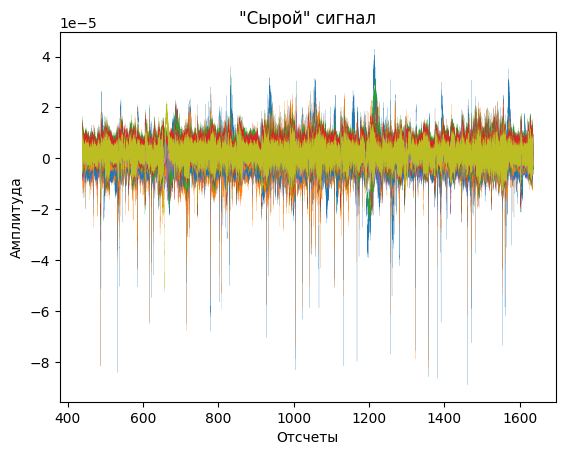

In [4]:
for i in range(len(data_from_raw_edf.ch_names)-2):
    plt.plot(t, eeg_data[i, t_index_begin:t_index_end],linewidth = 0.1)
plt.title("\"Сырой\" сигнал")
plt.xlabel("Отсчеты")
plt.ylabel("Амплитуда")
plt.show()

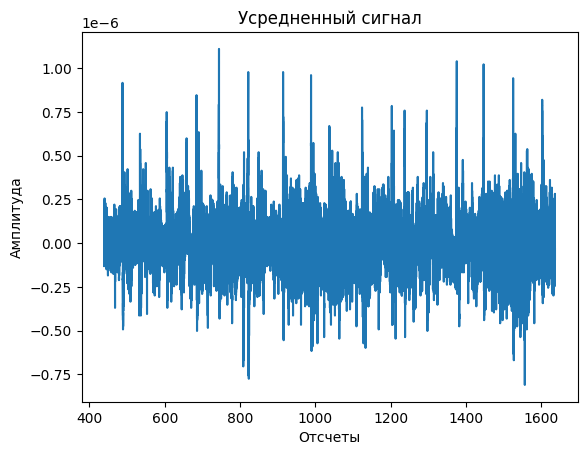

In [5]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-2):
    y =+ eeg_data[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)
plt.title("Усредненный сигнал")
plt.ylabel("Амплитуда")
plt.xlabel("Отсчеты")
plt.plot(t,y)
plt.show()

In [6]:
from scipy import signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

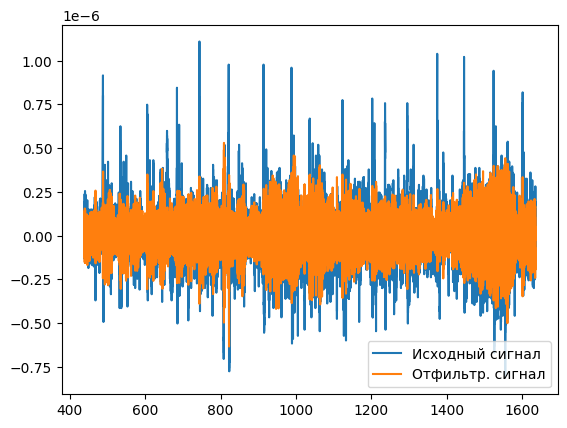

In [7]:
# Фильтрация сигнала
fs = len(t)/(T)  # частота дискретизации
lowcut = 1 # нижняя частота среза фильтра
highcut = 60 # верхняя частота среза фильтра
y_filt = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=lowcut, highcut=highcut, fs=fs)
plt.plot(t,y, t, y_filt)
plt.legend(["Исходный сигнал", "Отфильтр. сигнал"])
y = y_filt

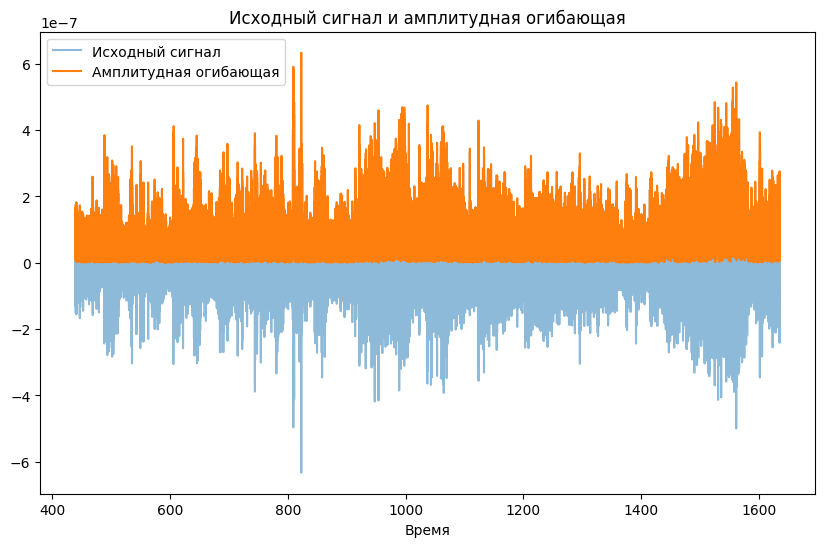

In [9]:
# функция преобразования Гильберта для построения огибающей
from scipy.fft import fft, ifft
def my_func_hilbert(x):
    N = len(x)
    xf = fft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = ifft(xf)
    assert np.allclose(xa.real, x)
    return xa

# Применяем преобразование Гильберта
analytic_signal = my_func_hilbert(y)
amplitude_envelope = np.abs(analytic_signal)  # Используем амплитуду для амплитудной огибающей

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Исходный сигнал', alpha=0.5)
plt.plot(t, amplitude_envelope, label='Амплитудная огибающая')


plt.title('Исходный сигнал и амплитудная огибающая')
plt.xlabel('Время')
plt.legend()

plt.show()

<Figure size 640x480 with 0 Axes>

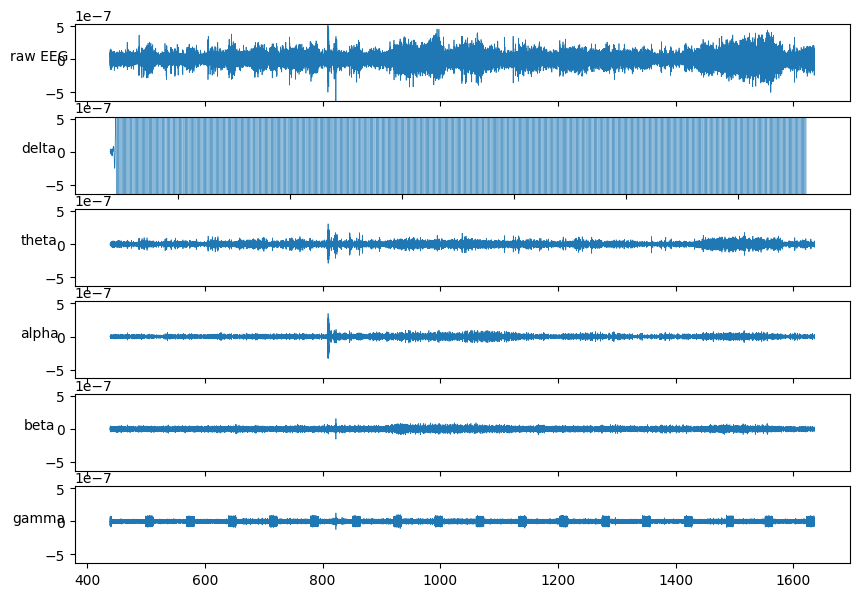

In [10]:
# Определение частотных диапазонов
delta_band = (0.5, 4)
theta_band = (4, 8)
alpha_band = (8, 13)
beta_band = (13, 30)
gamma_band = (30, 75)

band_names = ('delta','theta','alpha','beta','gamma')
band_value = (0.5, 4, 8, 13, 30, 50)
fs = int(len(t)/(T))  # частота дискретизации

fig = plt.figure()
fig, ax = plt.subplots(6,1,figsize=(10,7))
ax[0].set_ylim(np.min(y), np.max(y))
ax[0].plot(t, y,linewidth = 0.5)
ax[0].set_ylabel('raw EEG', rotation = 0)

for i in range(1,6):
    ax[i].set_ylim(np.min(y), np.max(y))
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    #ax[i-1].set_yticklabels([])
    ax[i-1].set_xticklabels([])
    ax[i].set_ylabel(band_names[i-1], rotation = 0)
    filtered_signals = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=band_value[i-1], highcut=band_value[i], fs=fs)
    ax[i].plot(t, filtered_signals,linewidth = 0.5)

<Figure size 640x480 with 0 Axes>

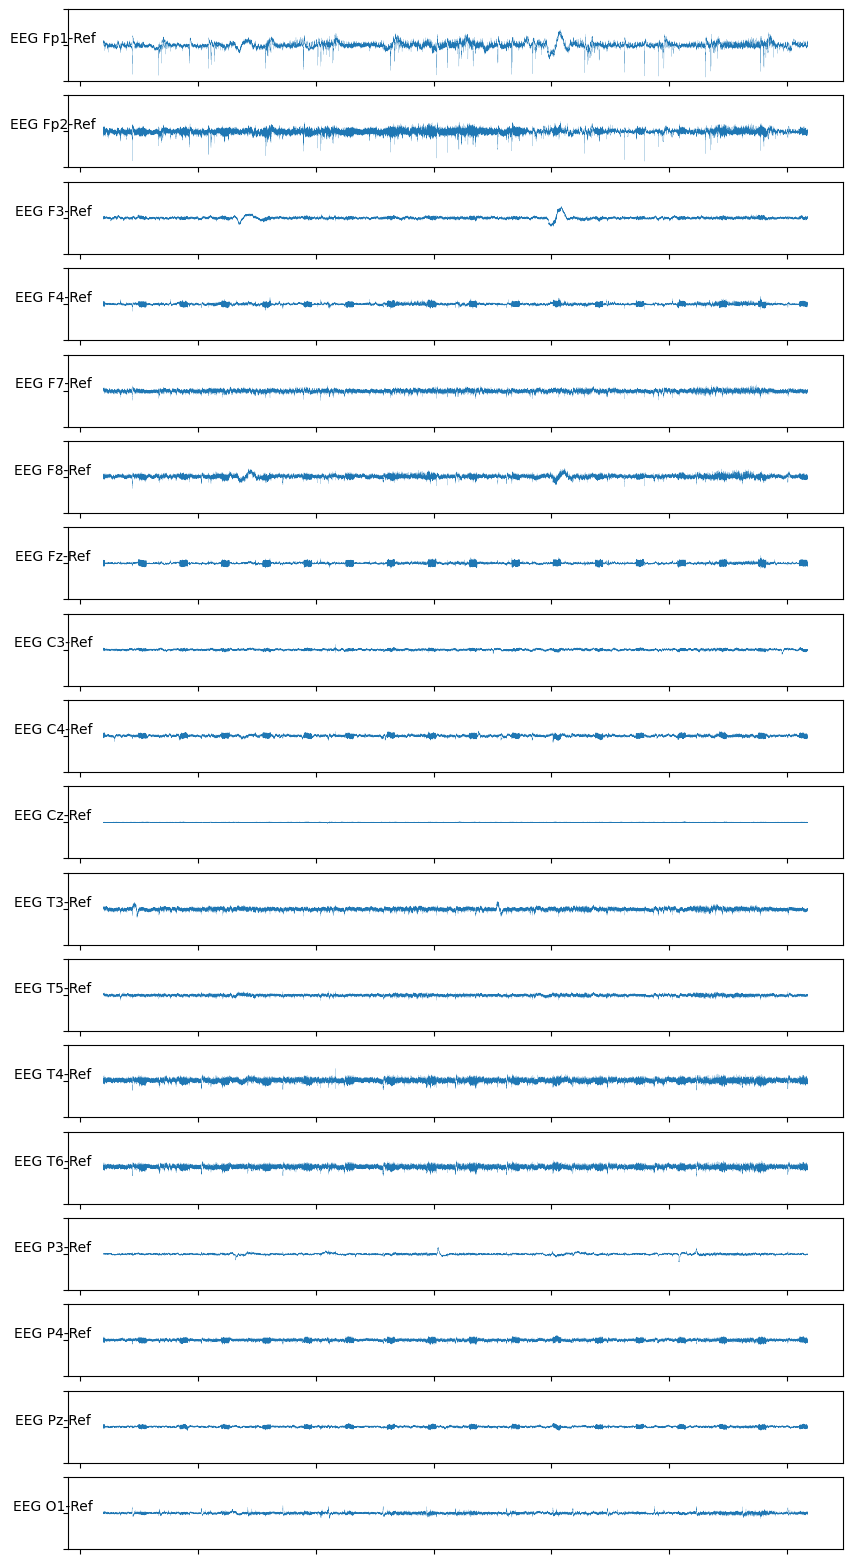

In [11]:
# визуализация каналов ЭЭГ
from matplotlib.ticker import FormatStrFormatter

sublplot_EEG_number = 18
fig = plt.figure()
fig, ax = plt.subplots(sublplot_EEG_number,1,figsize=(10,20))

for i in range(1,sublplot_EEG_number+1):
    #ax = fig.add_subplot(8, 1, i)
    ax[i-1].set_ylim(-0.0001, 0.0001)
    #ax[i-1].set_yticklabels(np.arange(-25, 25, step=25))
    ax[i-1].set_yticklabels([])
    ax[i-1].set_xticklabels([])
    ax[i-1].set_ylabel(data_from_raw_edf.ch_names[i-1], rotation = 0)
    ax[i-1].plot(t, eeg_data[i-1, t_index_begin:t_index_end],linewidth = 0.1)

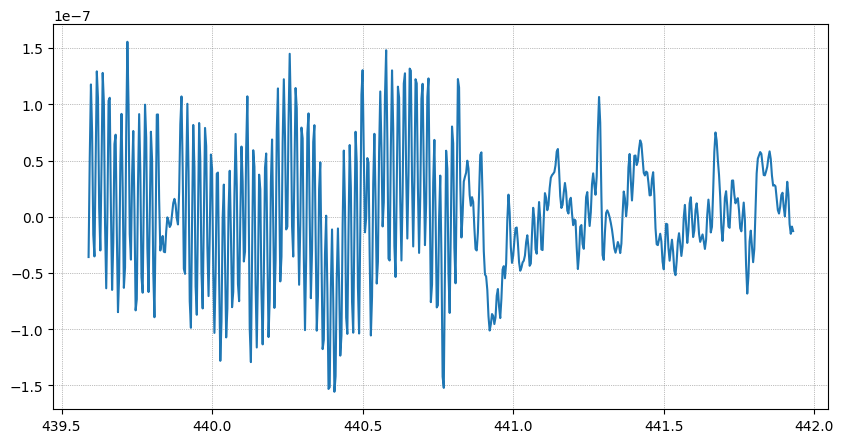

In [12]:
index_view = np.arange(150,750,1)
plt.figure(figsize=(10, 5))
plt.plot(t[index_view], y[index_view])
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

число точек в диапазоне преобразования Фурье: 153216
максимальная частота 127.99958228769283


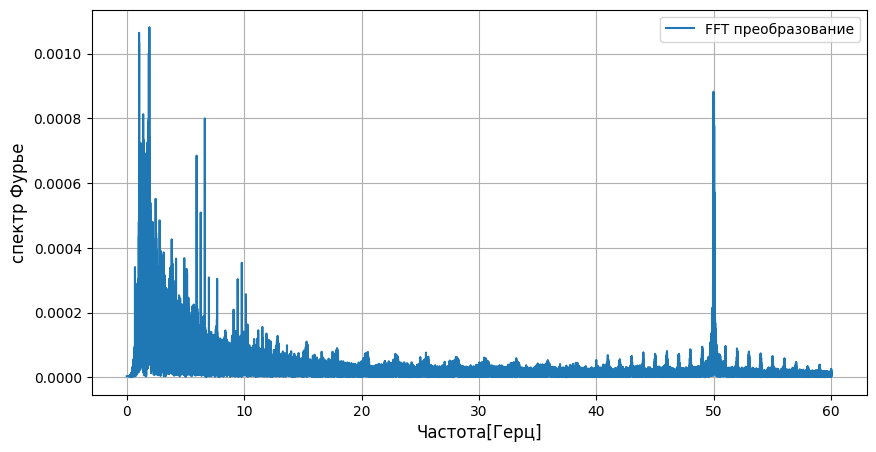

In [13]:
from scipy.fft import fft, fftfreq

y = y_filt
yfft = fft(y)
xf = fftfreq(N, T/N)[:N//2]
yf = np.abs(yfft[0:N//2])

# устанавливаем максимальную частоту для отображения на графике преобразования Фурье
f_viewmax = 60
if len(np.where(xf > f_viewmax)[0]) == 0:
  index_f_viewmax = len(xf)
else:
  index_f_viewmax = np.where(xf > f_viewmax)[0][0]
print('число точек в диапазоне преобразования Фурье:',len(xf))
print('максимальная частота', xf[-1])
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf[0:index_f_viewmax], yf[0:index_f_viewmax], label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
#plt.xticks(np.arange(1, np.max(xf[0:100]), 2))
plt.grid()
plt.legend()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


C:\Users\a_rad\AppData\Local\Temp\ipykernel_18100\112353675.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_from_raw_edf.plot_psd(fmin=1, fmax=f_viewmax, tmax=np.inf, show=False)


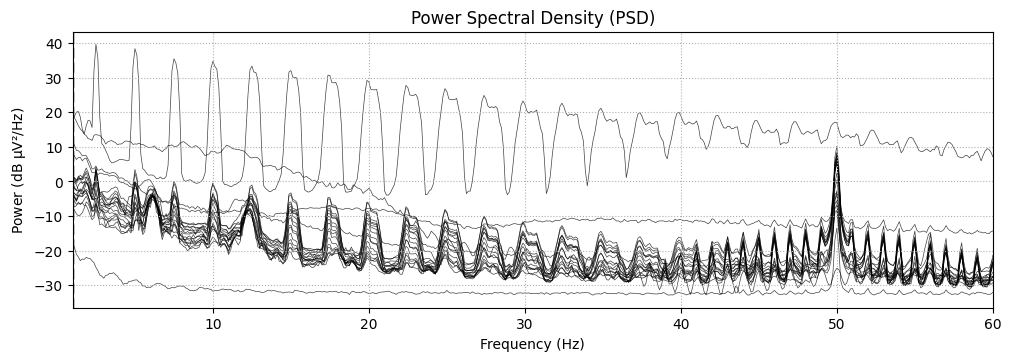

In [14]:
# Построение спектра плотности мощности
data_from_raw_edf.plot_psd(fmin=1, fmax=f_viewmax, tmax=np.inf, show=False)
plt.title('Power Spectral Density (PSD)')
plt.show()

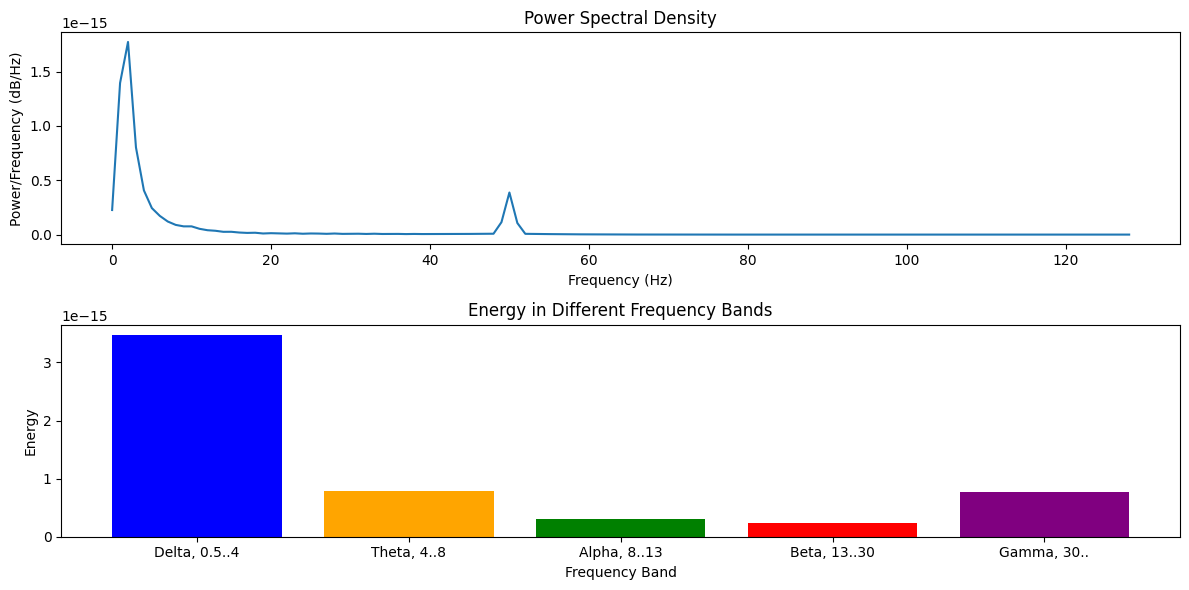

In [15]:
from scipy.signal import welch

# Функция для вычисления энергии в заданном частотном диапазоне
def compute_energy_in_frequency_band(freqs, psd, band):
    indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    energy = np.trapz(psd[indices], freqs[indices])
    return energy

# Функция для построения спектрограммы и вычисления энергии в различных частотных диапазонах
def plot_spectrogram_and_energy(signal, sample_rate):
    # Вычисление мощности спектра с помощью метода Велча
    freqs, psd = welch(signal, sample_rate)#, nperseg=1024)

    # Определение частотных диапазонов
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 100)

    # Вычисление энергии в каждом частотном диапазоне
    energy_delta = compute_energy_in_frequency_band(freqs, psd, delta_band)
    energy_theta = compute_energy_in_frequency_band(freqs, psd, theta_band)
    energy_alpha = compute_energy_in_frequency_band(freqs, psd, alpha_band)
    energy_beta  = compute_energy_in_frequency_band(freqs, psd, beta_band)
    energy_gamma = compute_energy_in_frequency_band(freqs, psd, gamma_band)

    # Построение спектрограммы
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, psd)
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')

    # Построение энергии в различных частотных диапазонах
    plt.subplot(2, 1, 2)
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    energies = [energy_delta, energy_theta, energy_alpha, energy_beta, energy_gamma]
    plt.bar(bands, energies, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.title('Energy in Different Frequency Bands')
    plt.xlabel('Frequency Band')
    plt.xticks(np.arange(5), ('Delta, 0.5..4', 'Theta, 4..8', 'Alpha, 8..13', 'Beta, 13..30', 'Gamma, 30..'))
    plt.ylabel('Energy')

    plt.tight_layout()
    plt.show()

#sample_rate частота дискретизации
sample_rate = fs
plot_spectrogram_and_energy(y, sample_rate)

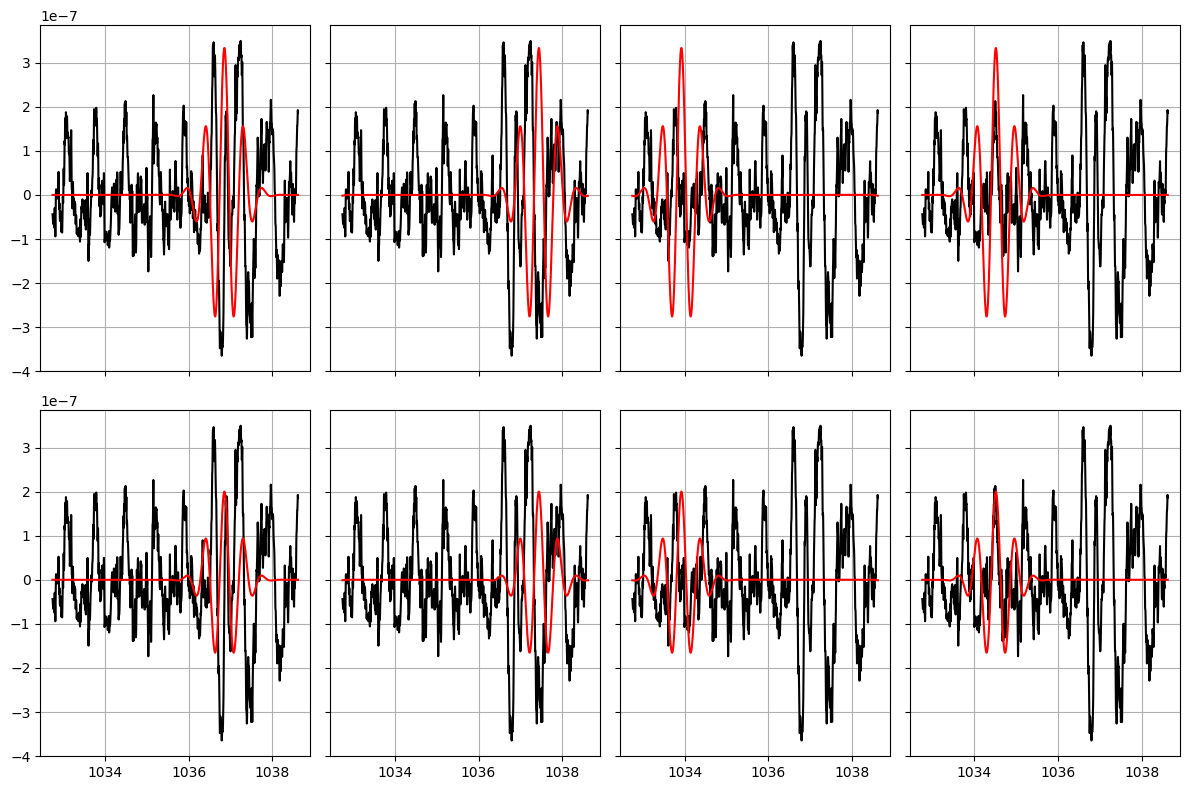

In [16]:
def generate_morlet_wavelet(t, scale, shift):
    # Создаем объект непрерывного вейвлета Морле
    wavelet = pywt.ContinuousWavelet('morl')
    
    # Генерируем вейвлет с заданным масштабом и сдвигом
    wavelet_function, _ = wavelet.wavefun(length=len(t))
    wavelet_function = wavelet_function / scale  # Нормализация по масштабу
    wavelet_function = np.roll(wavelet_function, int(shift * len(t)))  # Сдвиг
    
    return wavelet_function

# Параметры для графиков
scales = [int(0.3e7), int(0.5e7)]  # Разные масштабы
shifts = [0.2, 0.3, 0.7, 0.8]  # Разные сдвиги

# Создаем сетку графиков
fig, axes = plt.subplots(len(scales), len(shifts), figsize=(12, 8), sharex=True, sharey=True)

index = np.arange(152000, 153500, 1)
t_index = t[index]
y_index = y[index]
# Цикл по всем комбинациям масштабов и сдвигов
for i, scale in enumerate(scales):
    for j, shift in enumerate(shifts):
        # Генерируем вейвлет
        wavelet = generate_morlet_wavelet(t_index, scale, shift)
        
        # Отрисовываем исходный сигнал и вейвлет
        axes[i, j].plot(t_index, y_index, color='black')
        axes[i, j].plot(t_index, wavelet, color='red')
        
        # Настройки графика
        axes[i, j].grid()

# Настройка общего вида графика
plt.tight_layout()
plt.show()

In [17]:
# перечень вейвлетов
wavlist_continuous = pywt.wavelist(kind='continuous')
wavlist_discrete = pywt.wavelist(kind='discrete')

In [18]:
# устанавливаем максимальное значение сдвига
# не путать с частотой

#For the cmor, fbsp and shan wavelets, the user can specify a specific a normalized center frequency.
#A value of 1.0 corresponds to 1/dt where dt is the sampling period.
#In other words, when analyzing a signal sampled at 100 Hz,
#a center frequency of 1.0 corresponds to ~100 Hz at scale = 1.
#This is above the Nyquist rate of 50 Hz, so for this particular wavelet, one would analyze a signal using scales >= 2.

scale_max = 300
scale_min = 3
# массив точек с масштабом (линейный и логарифмический масштаб)
scales = np.linspace(scale_min, scale_max, num = 25, endpoint=True)
#scales = np.logspace(np.log10(scale_min), np.log10(scale_max), num = 25, endpoint=True, base=10.0)

wavelet_core = 'morl'
#dt = t[1] - t[0]
fs = len(t)/(T)  # частота дискретизации
dt = 1/ fs
coef, freqs = pywt.cwt(y, scales, wavelet_core, sampling_period = dt)

# freqs = These are normalized frequencies, which means that you need
# to multiply them by your sampling frequency = fs
# to turn them into actual frequencies.

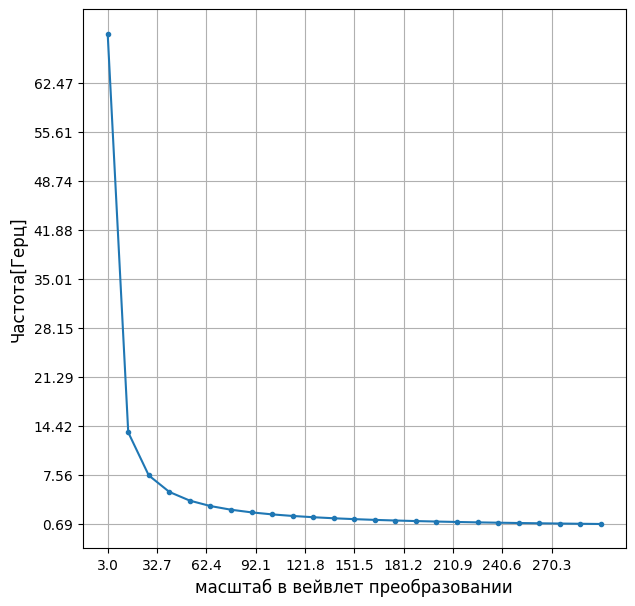

In [19]:
# вейвлет-преобразование построено относительно масштаба материнского вейвлета
# чтобы вернуться в область частот - необходимо перевести масштаб в частоту!
#f = pywt.scale2frequency(wavelet_core, scales)/(T/N)
f = pywt.scale2frequency(wavelet_core, scales)/dt

# изобразим график зависимости частоты и масштаба
plt.figure(figsize=(7, 7))
plt.grid()
plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('Частота[Герц]', fontsize=12)
plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
plt.plot(scales, freqs,'.-')

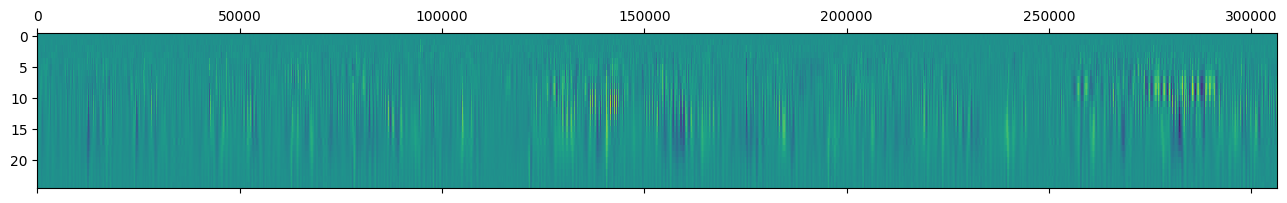

In [20]:
plt.matshow(coef,aspect = 'auto')

Text(0.5, 1.0, 'сигнал в области времени')

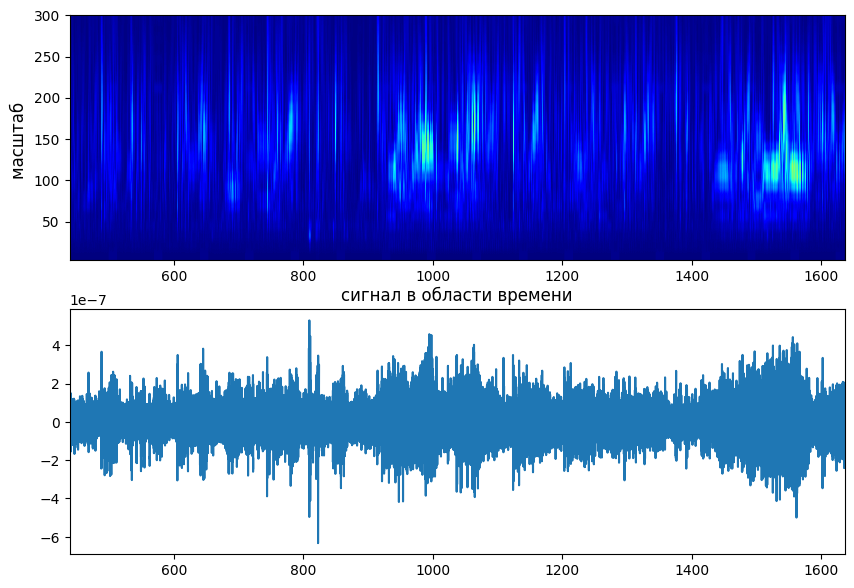

In [21]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(211)
#plt.imshow(abs(coef), extent=[t[0], t[-1], scale_max, 0], interpolation='bilinear', cmap='plasma', aspect='auto')
plt.imshow(abs(coef), cmap='jet', aspect='auto', extent=[t[0], t[-1], max(scales), min(scales)], vmax=abs(coef).max(), vmin=abs(coef).min())
plt.gca().invert_yaxis ()
plt.ylabel('масштаб ', fontsize=12)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t, y)
ax2.set_title("сигнал в области времени")

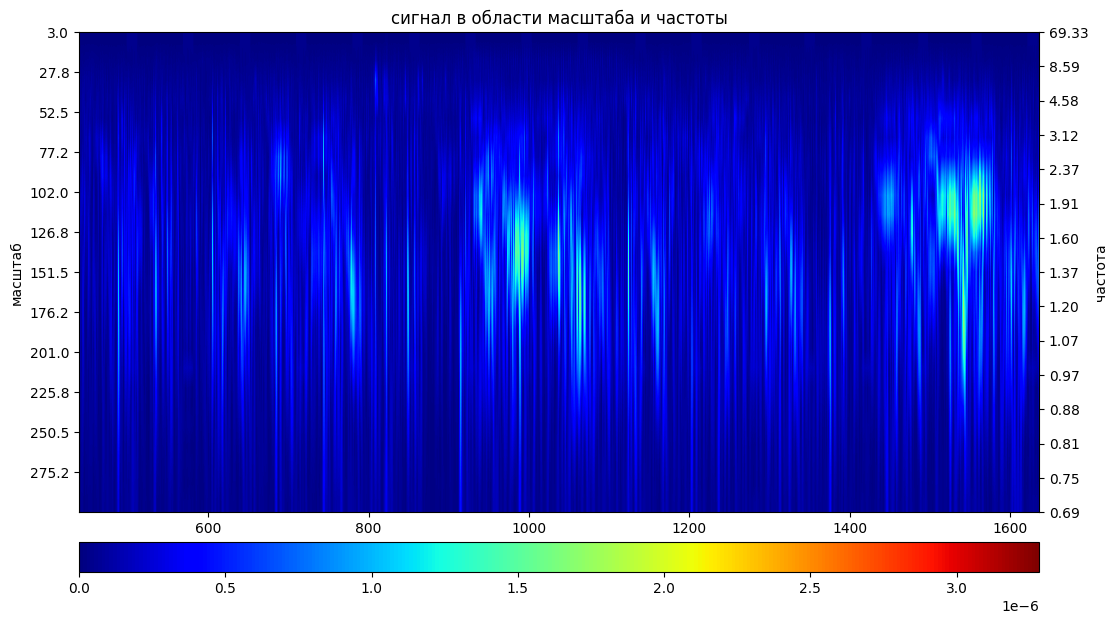

In [22]:
from matplotlib.figure import cbar
from matplotlib.ticker import FuncFormatter
import mpl_toolkits.axes_grid1 as axes_grid1
import matplotlib.ticker as ticker

#Plotting dual axis scalogram
f1 = plt.figure()
f1.set_size_inches(12, 6)


ax1 = axes_grid1.host_axes([0.1, 0.1, 0.8, 0.80])
axc = f1.add_axes([0.1, 0, 0.8, 0.05])
im1 = ax1.imshow(abs(coef), cmap='jet', aspect='auto', interpolation='bilinear',
                 extent=[t[0], t[-1], max(scales), min(scales)],
                 vmax=abs(coef).max(), vmin=-abs(coef).min())

cbar.Colorbar(axc, im1, orientation='horizontal')

#ax1.invert_yaxis()
ax1.set_yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/12))


ax2 = ax1.twinx()
# make ticklabels on the top invisible
ax2.axis["top"].toggle(ticklabels=False)

formatter = FuncFormatter(lambda x, pos: '{:0.2f}'.format(pywt.scale2frequency(wavelet_core, x)/dt))
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylim(ax1.get_ylim())
#ax2.invert_yaxis()

# make number ticks what we want
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_major_locator(ticker.LinearLocator(numticks = 15))


ax2.set_ylabel('частота')
ax1.set_ylabel('масштаб')
ax2.set_xlabel('время')

ax1.set_title("сигнал в области масштаба и частоты")

plt.show()